# 🛡️ Predicting Arrests Using LAPD Crime Data
> *"Accessible Machine Learning from a Chromebook"*

This project uses publicly available LAPD crime data (2020–Present) to train and compare interpretable classification models that predict whether an arrest is likely during a stop or incident. Features include time, location, victim demographics, and crime type.

💡 Built entirely on a **Chromebook** using free, open-source tools to show that **anyone can do machine learning** — no GPU, no AWS required.

---

## 📦 Dataset Source
[LAPD Open Data Portal](https://data.lacity.org/)

---

## 🎯 Objective
To predict the likelihood of an arrest using a cleaned, compact set of features — and to demonstrate that meaningful ML work can be done using only JupyterLab and public data.


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.70      0.64      0.67     21719
           1       0.59      0.66      0.62     16961

    accuracy                           0.65     38680
   macro avg       0.64      0.65      0.64     38680
weighted avg       0.65      0.65      0.65     38680

Logistic Regression ROC-AUC Score: 0.6959281713060975


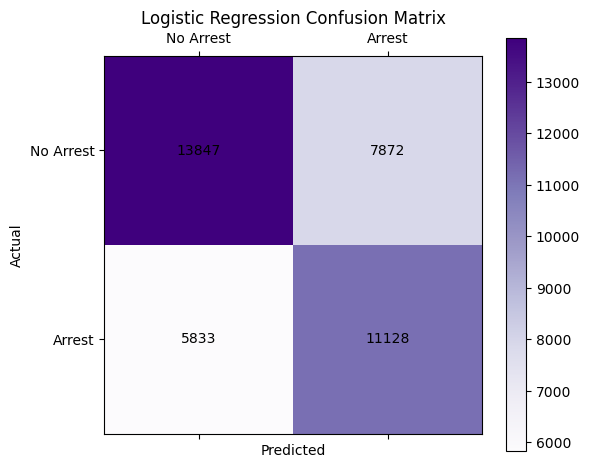

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.66      0.70      0.68     21719
           1       0.58      0.53      0.55     16961

    accuracy                           0.63     38680
   macro avg       0.62      0.62      0.62     38680
weighted avg       0.62      0.63      0.62     38680

Random Forest ROC-AUC Score: 0.6646073149415269


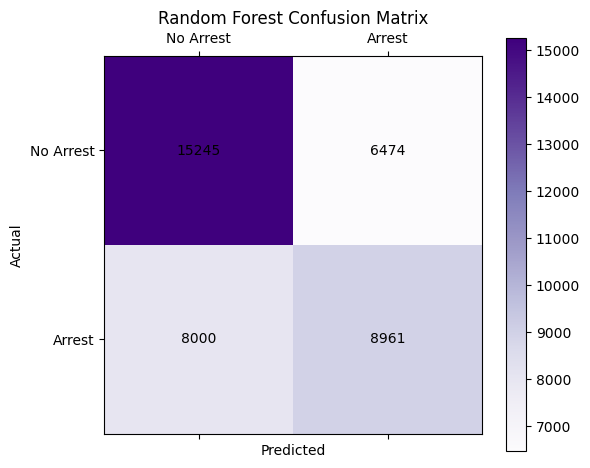

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv('arrests.csv')  # Use nrows=10000 for dev

# Create binary target
df['arrest_made'] = df['Status Desc'].apply(lambda x: 1 if 'Arrest' in str(x) else 0)
df.drop(columns=['Status Desc'], inplace=True)
df.dropna(subset=['Vict Sex', 'Vict Descent'], inplace=True)

# Collapse rare values into 'Other', avoiding hundreds of columns and lowering memory needs
top_crimes = df['Crm Cd Desc'].value_counts().nlargest(20).index
df['Crm Cd Desc'] = df['Crm Cd Desc'].where(df['Crm Cd Desc'].isin(top_crimes), 'Other')

# Ordinal encoding assigns 1 number per value, gives fewer columns, simpler and faster models
ordinal_cols = ['Vict Sex', 'Vict Descent']
df[ordinal_cols] = OrdinalEncoder().fit_transform(df[ordinal_cols])

# One-hot encode remaining categorical columns
df = pd.get_dummies(df, columns=['AREA NAME', 'Crm Cd Desc'], sparse=True)

# Prepare features and labels
y = df['arrest_made']
X = df.drop('arrest_made', axis=1)

# Convert to sparse matrix
X_dense = X.astype(float)
X_sparse = sparse.csr_matrix(X_dense.values)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

### Logistic Regression
lr_model = LogisticRegression(max_iter=5000, solver='saga', class_weight='balanced')  # Added class_weight
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

print("=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))

# Plot confusion matrix using matplotlib
def plot_confusion_matrix(cm, title, labels):
    fig, ax = plt.subplots(figsize=(6,5))
    cax = ax.matshow(cm, cmap='Purples')
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, str(z), ha='center', va='center')
    plt.tight_layout()
    plt.show()

cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, 'Logistic Regression Confusion Matrix', ['No Arrest', 'Arrest'])

### Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')  # Added class_weight
rf_model.fit(X_train.toarray(), y_train)
y_pred_rf = rf_model.predict(X_test.toarray())
y_proba_rf = rf_model.predict_proba(X_test.toarray())[:, 1]

print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, 'Random Forest Confusion Matrix', ['No Arrest', 'Arrest'])

## 🔍 Model Comparison: Logistic Regression vs Random Forest (Balanced Classes)

After training both models with `class_weight='balanced`, Logistic Regression was given 5000 iterations — and **successfully converged** (no warnings). This allowed the model to more fully optimize the loss function and improve predictive performance.

### ✅ Logistic Regression (Converged at 5000 iterations)
- **Accuracy:** ~65%
- **Precision (Arrest):** 0.59
- **Recall (Arrest):** 0.66
- **F1-Score (Arrest):** 0.62
- **ROC-AUC:** ~0.70

**Confusion Matrix**
- ✅ True Positives (correct arrests): **11,128**
- ❌ False Negatives (missed arrests): **5,833**
- ❌ False Positives (wrongly predicted arrests): **7,872**

---

### 🌲 Random Forest
- **Accuracy:** ~63%
- **Precision (Arrest):** 0.58
- **Recall (Arrest):** 0.53
- **F1-Score (Arrest):** 0.55
- **ROC-AUC:** ~0.66

**Confusion Matrix**
- ✅ True Positives (correct arrests): **8,961**
- ❌ False Negatives (missed arrests): **8,000**
- ❌ False Positives (wrongly predicted arrests): **6,474**

---

### 🧠 Interpretation

- Logistic Regression **benefited from class balancing and additional training iterations**, leading to higher recall and ROC-AUC.
- Random Forest performed well but **struggled more to correctly identify arrests** (Class 1), despite being more complex.
- These results highlight that **simpler models can outperform complex ones** when properly tuned and interpreted.

---
> ✅ **Conclusion:** Logistic Regression is currently the better-performing model for this task — and also easier to interpret, making it a great choice for real-world applications, especially when working with limited compute resources.
